<a href="https://colab.research.google.com/github/ilinashah177/Coursework-Website/blob/main/Copy_of_Regression_Investments_and_Energy_Capacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#Draw graphs "inline" in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np
#Make the plots (graphs) a little wider by default
pylab.rcParams['figure.figsize'] = (10., 8.)
sns.set(font_scale=1.5)
sns.set_style("white")

In [91]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving Dataset Group14.xlsx to Dataset Group14 (1).xlsx


In [92]:
import pandas as pd

#Name of uploaded file
file_name = 'Dataset Group14.xlsx'

#Read data from the two sheets
sheet1_df = pd.read_excel(file_name, sheet_name='BRI investments')
sheet2_df = pd.read_excel(file_name, sheet_name='TECA')

#Print data from both sheets
print("Data from Sheet1:")
print(sheet1_df.head())

print("Data from Sheet2:")
print(sheet2_df.head())

Data from Sheet1:
   Year  BRI Investments in Energy Sector (USD millions)
0  2015                                           520.40
1  2016                                           893.25
2  2017                                          2296.00
3  2018                                          2062.00
4  2019                                          2907.00
Data from Sheet2:
   Year  Total Energy Capacity Added from Completed CPEC Projects (MW)
0  2015                                                400            
1  2016                                                650            
2  2017                                               1469            
3  2018                                               1420            
4  2019                                               1980            


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#Merge the two DataFrames based on the 'Year' column
data = pd.merge(sheet1_df, sheet2_df, on='Year')
data.head()

,Year,BRI Investments in Energy Sector (USD millions),Total Energy Capacity Added from Completed CPEC Projects (MW)
0,2015,520.40,400
1,2016,893.25,650
2,2017,2296.00,1469
3,2018,2062.00,1420
4,2019,2907.00,1980


In [5]:
#Generate summary statistics, and round everything to 2 decimal places
summary=data.describe().round(2)
summary

,Year,BRI Investments in Energy Sector (USD millions),Total Energy Capacity Added from Completed CPEC Projects (MW)
count,10.00,10.00,10.00
mean,2019.50,1809.26,1419.00
std,3.03,750.38,1023.98
min,2015.00,520.40,400.00
25%,2017.25,1480.00,743.25
50%,2019.50,1829.00,1350.00
75%,2021.75,2237.50,1456.75
max,2024.00,2907.00,4000.00


In [6]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

#Define outliers as data points outside of Q1 - 1.5*IQR or Q3 + 1.5*IQR
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)

#Remove outliers
data_cleaned = data[~outliers]
print(data_cleaned)

   Year  BRI Investments in Energy Sector (USD millions)  \
0  2015                                           520.40   
1  2016                                           893.25   
2  2017                                          2296.00   
3  2018                                          2062.00   
4  2019                                          2907.00   
5  2020                                          1600.00   
7  2022                                          2716.00   
8  2023                                          1440.00   
9  2024                                          2000.00   

   Total Energy Capacity Added from Completed CPEC Projects (MW)  
0                                                400              
1                                                650              
2                                               1469              
3                                               1420              
4                                               1980            

Text(69.75, 0.5, 'Total Energy Capacity Added from Completed CPEC Projects (MW)')

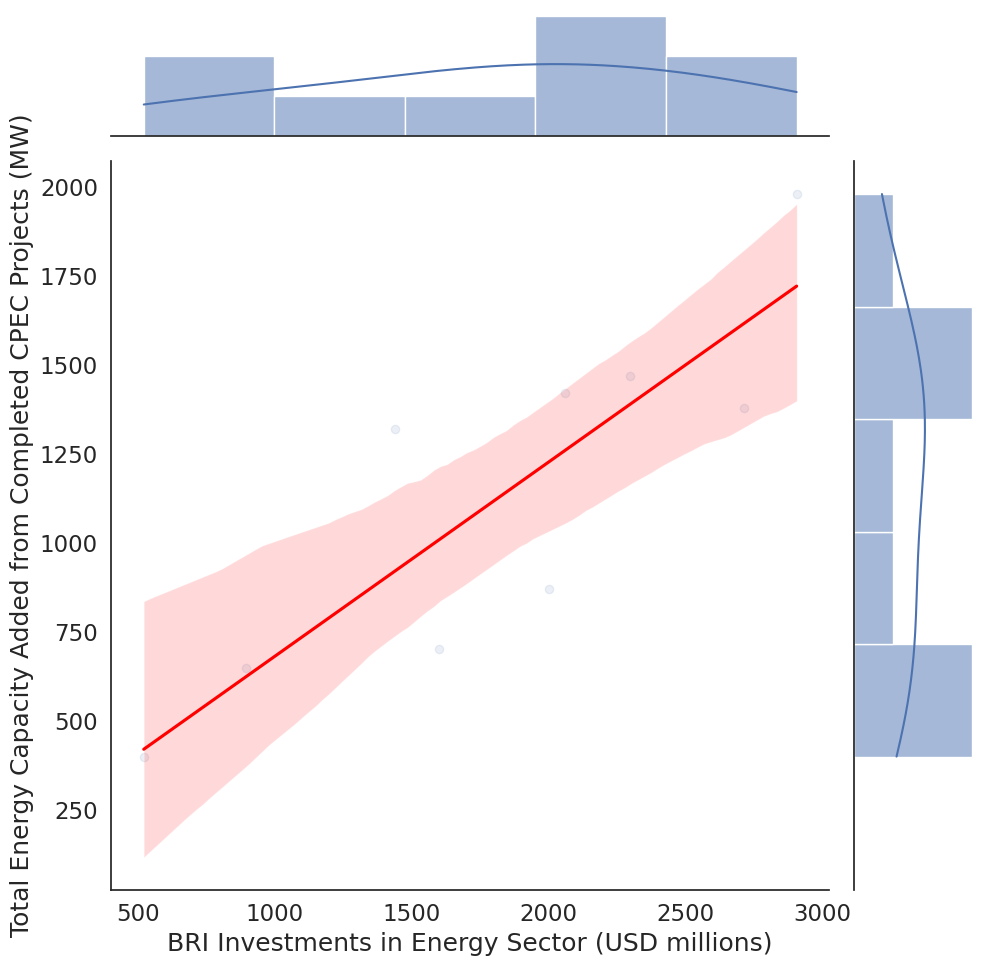

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#Plot scatterplot and two histograms
sns.jointplot(data=data_cleaned,
              x='BRI Investments in Energy Sector (USD millions)',
              y='Total Energy Capacity Added from Completed CPEC Projects (MW)',
              kind="reg",
              scatter_kws=dict(alpha=0.1),
              line_kws=dict(color='red'),
              height=10)

#Add labels to the axes
plt.xlabel('BRI Investments in Energy Sector (USD millions)')
plt.ylabel('Total Energy Capacity Added from Completed CPEC Projects (MW)')

Text(0.5, 1.0, 'Correlation Matrix')

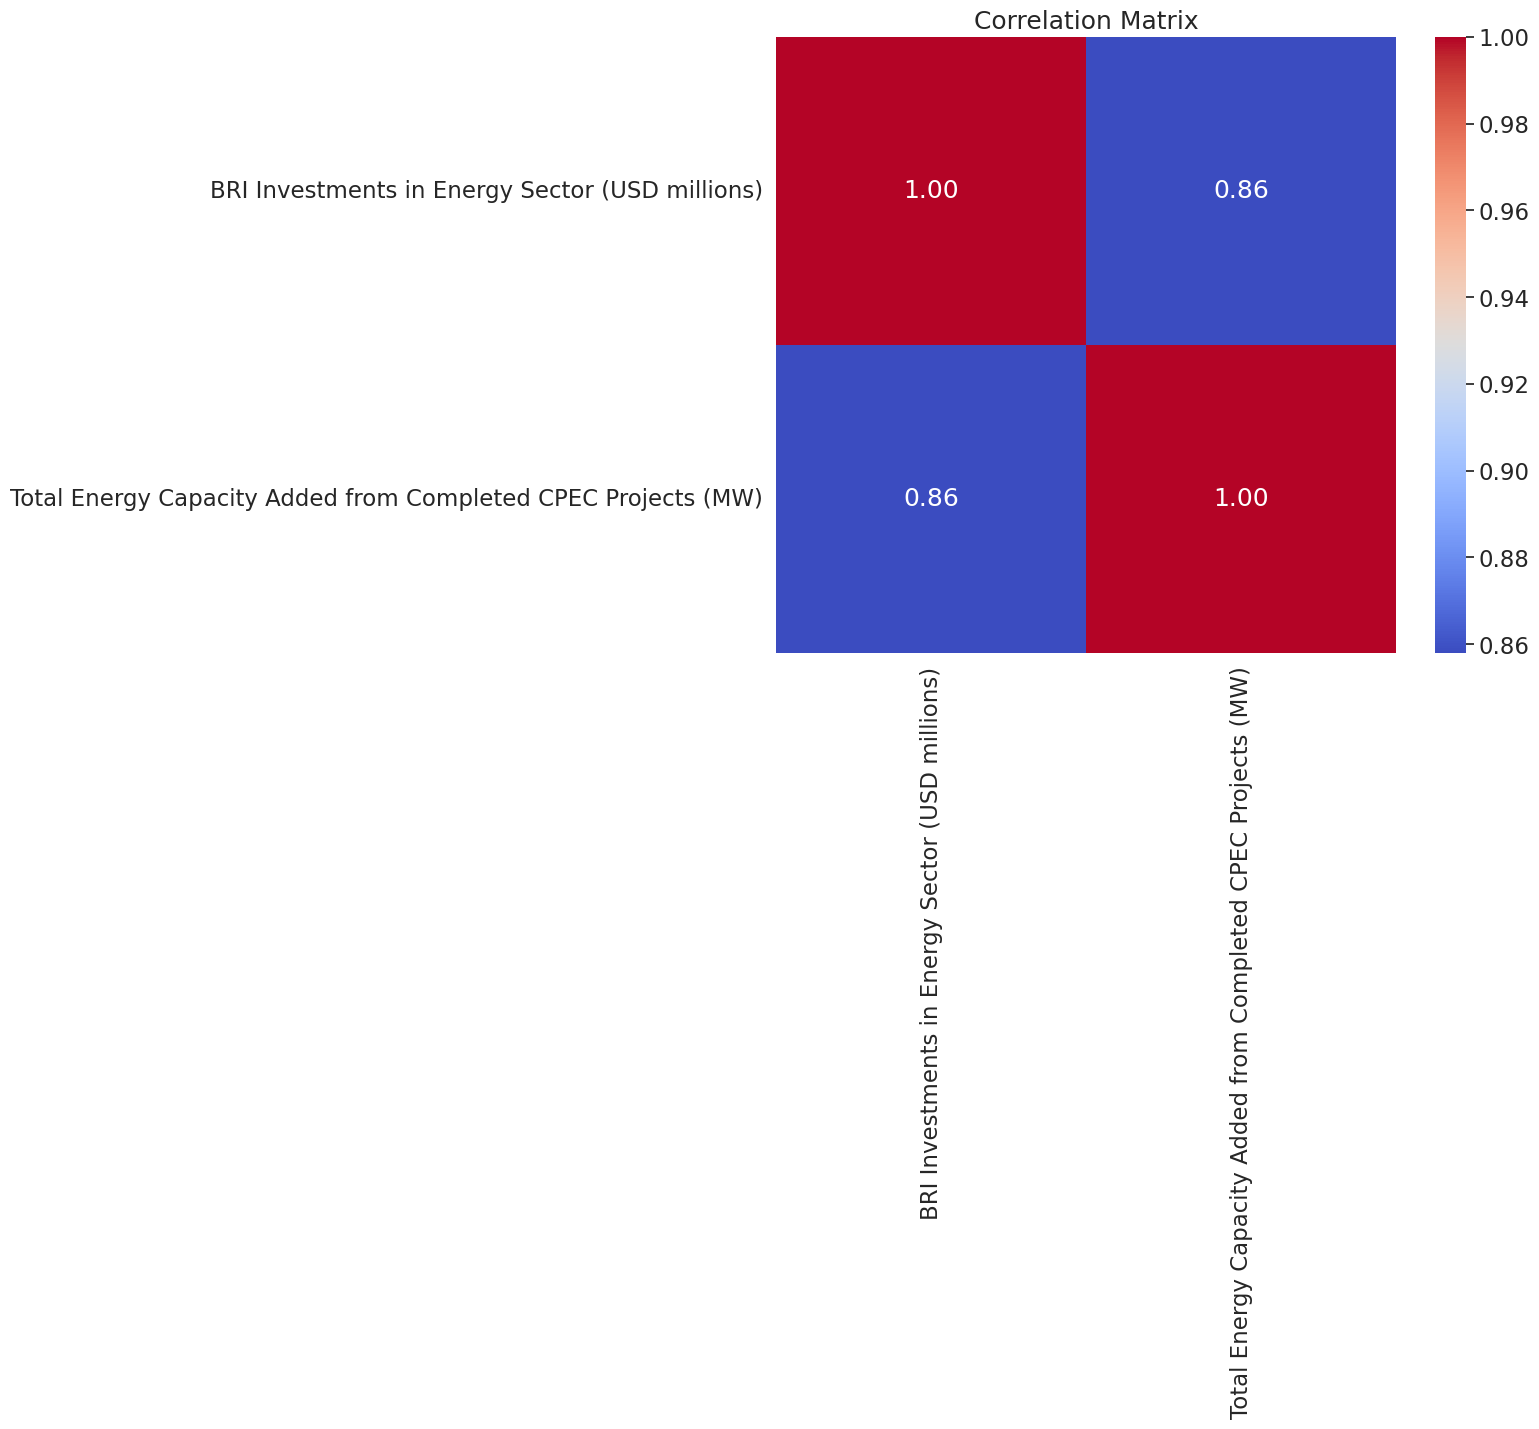

In [8]:
sns.heatmap(data_cleaned[['BRI Investments in Energy Sector (USD millions)','Total Energy Capacity Added from Completed CPEC Projects (MW)']].corr(), #Plot a correlation matrix
            annot=True, #Show the correlation values on the plot
            fmt=".2f", #Set the format of the correlation values to be two decimal places
            cmap='coolwarm') #Set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') #Add a title

In [53]:
#Calculating VIF
#This function is amended from: https://stackoverflow.com/a/51329496/4667568

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(data_cleaned, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    # Initialize df with data_cleaned to ensure it's defined
    df = data_cleaned.copy()

    while True:
        #Adding a constant item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        #Drop the const as const should not be removed
        vif_df = vif_df.drop('const')

        #Drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)

        print('Max VIF:', vif_df.VIF.max())

        #If the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            #If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            #No VIF is above threshold, exit the loop
            break

    return df

In [55]:
vars=['BRI Investments in Energy Sector (USD millions)','Total Energy Capacity Added from Completed CPEC Projects (MW)']

vif = drop_column_using_vif_(data_cleaned[vars], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif.columns)

Max VIF: 3.7893574453998093
The columns remaining after VIF selection are:
Index(['BRI Investments in Energy Sector (USD millions)', 'Total Energy Capacity Added from Completed CPEC Projects (MW)'], dtype='object')


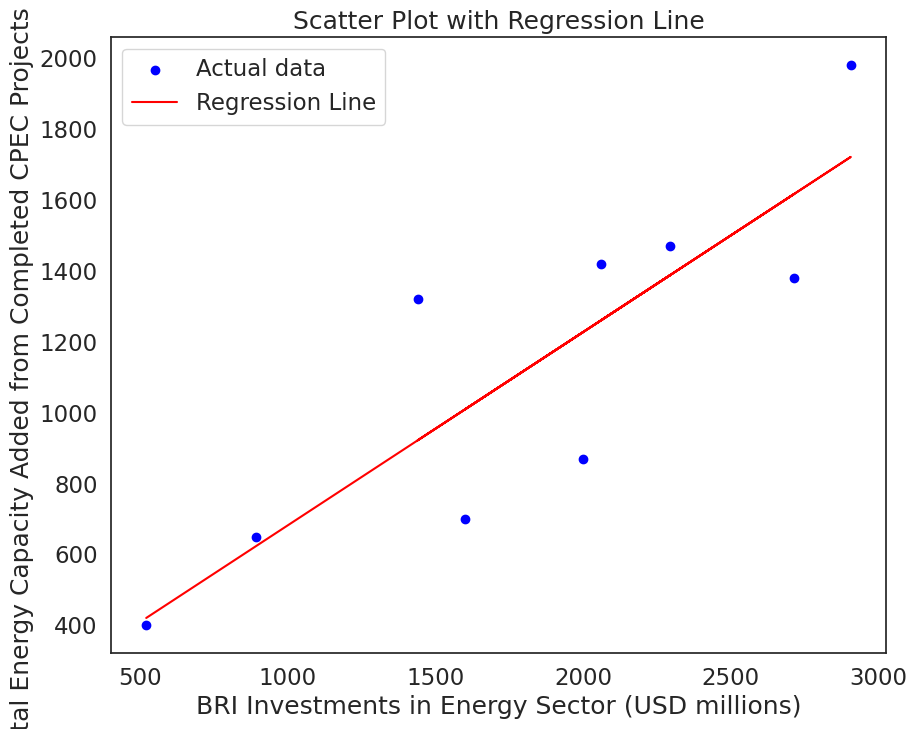

In [12]:
#Select features (X) and target (y)
X = data_cleaned[['BRI Investments in Energy Sector (USD millions)']]
y = data_cleaned['Total Energy Capacity Added from Completed CPEC Projects (MW)']

#Perform Linear Regression
model = LinearRegression()
model.fit(X, y)

#Predict values using the regression model
y_pred = model.predict(X)

#Create the scatter plot
plt.scatter(X, y, color='blue', label='Actual data')

#Plot the regression line
plt.plot(X, y_pred, color='red', label='Regression Line')

#Add labels and title
plt.xlabel('BRI Investments in Energy Sector (USD millions)')
plt.ylabel('Total Energy Capacity Added from Completed CPEC Projects (MW)')
plt.title('Scatter Plot with Regression Line')
plt.legend()

#Show the plot
plt.show()

In [13]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

In [15]:
#Fit the model
model=ols('Q("Total Energy Capacity Added from Completed CPEC Projects (MW)") ~ Q("BRI Investments in Energy Sector (USD millions)")', data=data_cleaned).fit()
print(model.summary())

                                                    OLS Regression Results                                                    
Dep. Variable:     Q("Total Energy Capacity Added from Completed CPEC Projects (MW)")   R-squared:                       0.736
Model:                                                                            OLS   Adj. R-squared:                  0.698
Method:                                                                 Least Squares   F-statistic:                     19.53
Date:                                                                Thu, 02 Jan 2025   Prob (F-statistic):            0.00309
Time:                                                                        14:42:58   Log-Likelihood:                -62.255
No. Observations:                                                                   9   AIC:                             128.5
Df Residuals:                                                                       7   BIC:                   

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)


In [16]:
print('The t-statistic for this regression model is 4.419.')
print('The p-value for this regression model is 0.003.')
print('As the p-value is less than 0.05, the null hypothesis is rejected, and there is a statistically significant relationship between the two variables.')

The t-statistic for this regression model is 4.419.
The p-value for this regression model is 0.003.
As the p-value is less than 0.05, the null hypothesis is rejected, and there is a statistically significant relationship between the two variables.


In [90]:
#Draw graphs "inline" in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np
#Make the plots (graphs) a little wider by default
pylab.rcParams['figure.figsize'] = (10., 8.)
sns.set(font_scale=1.5)
sns.set_style("white")

from google.colab import files

# Upload the file
uploaded = files.upload()

Saving Dataset Group14.xlsx to Dataset Group14.xlsx


In [93]:
import pandas as pd

#Name of uploaded file
file_name = 'Dataset Group14.xlsx'

#Read data from the two sheets
sheet1_df2 = pd.read_excel(file_name, sheet_name='TECA')
sheet2_df2 = pd.read_excel(file_name, sheet_name='Energy consumption')

def remove_unnamed_columns(df):
  """Removes columns with names starting with 'Unnamed'."""
  unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
  return df.drop(columns=unnamed_cols)

sheet1_df2_cleaned = remove_unnamed_columns(sheet1_df2)
sheet2_df2_cleaned = remove_unnamed_columns(sheet2_df2)

In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#Merge the two DataFrames based on the 'Year' column
data2 = pd.merge(sheet1_df2_cleaned, sheet2_df2_cleaned, on='Year')
data2.head()

,Year,Total Energy Capacity Added from Completed CPEC Projects (MW),Total electricity consumption (GWh)
0,2015,400,85818
1,2016,650,90431
2,2017,1469,95529
3,2018,1420,106928
4,2019,1980,109461


In [95]:
summary2=data2.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary2

,Year,Total Energy Capacity Added from Completed CPEC Projects (MW),Total electricity consumption (GWh)
count,10.00,10.00,10.00
mean,2019.50,1419.00,104968.10
std,3.03,1023.98,10559.00
min,2015.00,400.00,85818.00
25%,2017.25,743.25,98378.75
50%,2019.50,1350.00,108916.00
75%,2021.75,1456.75,111138.25
max,2024.00,4000.00,116816.00


In [96]:
Q1_2 = data2.quantile(0.25)
Q3_2 = data2.quantile(0.75)
IQR_2 = Q3_2 - Q1_2

#Define outliers as data points outside of Q1 - 1.5*IQR or Q3 + 1.5*IQR
outliers2 = ((data2 < (Q1_2 - 1.5 * IQR_2)) | (data2 > (Q3_2 + 1.5 * IQR_2))).any(axis=1)

#Remove outliers
data_cleaned2 = data2[~outliers]
print(data_cleaned2)

   Year  Total Energy Capacity Added from Completed CPEC Projects (MW)  \
0  2015                                                400               
1  2016                                                650               
2  2017                                               1469               
3  2018                                               1420               
4  2019                                               1980               
5  2020                                                701               
6  2021                                               4000               
7  2022                                               1380               
8  2023                                               1320               
9  2024                                                870               

   Total electricity consumption (GWh)  
0                                85818  
1                                90431  
2                                95529  
3                    

Text(69.75, 0.5, 'Total electricity consumption (GWh)')

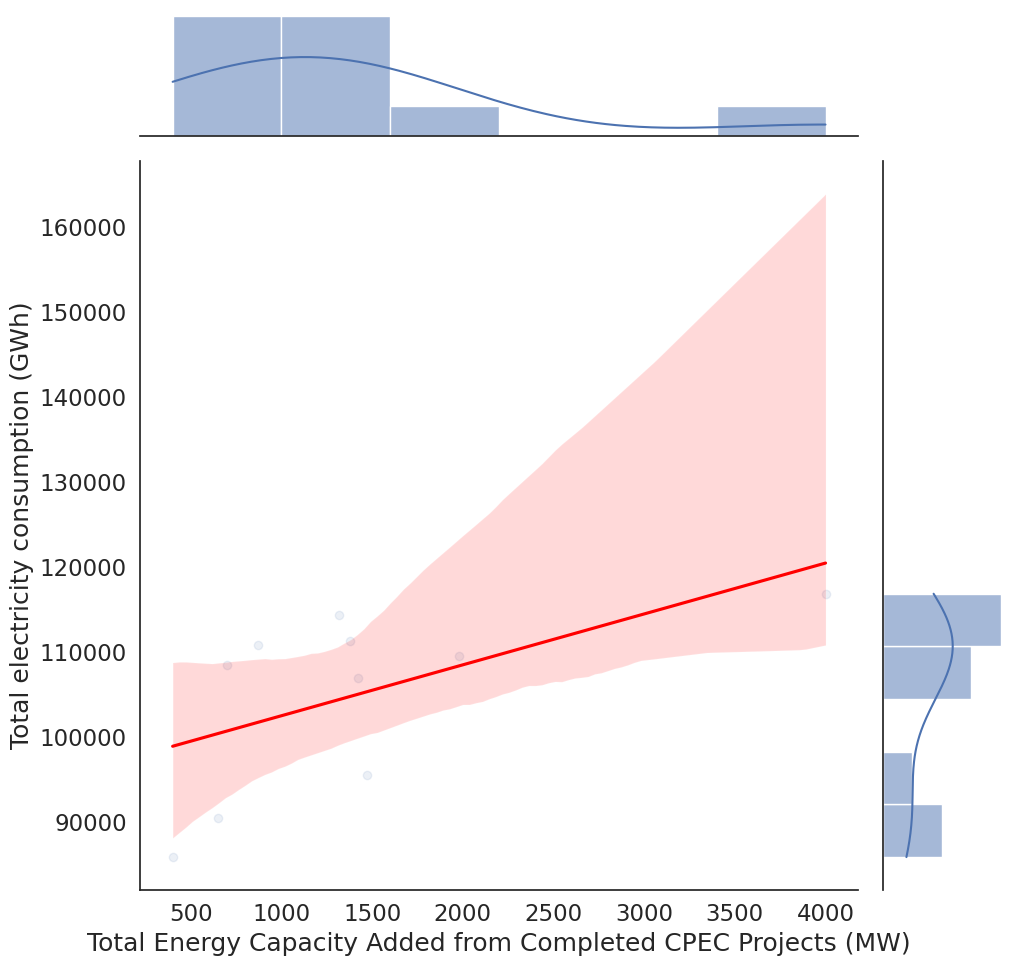

In [97]:
sns.jointplot(data=data2, # plot a scatterplot with a regression line and two histograms
                x='Total Energy Capacity Added from Completed CPEC Projects (MW)', # set the x axis to be the years of schooling
                y='Total electricity consumption (GWh)', # set the y axis to be the hourly wage
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Total Energy Capacity Added from Completed CPEC Projects (MW)') # add a label to the x axis
plt.ylabel('Total electricity consumption (GWh)') # add a label to the y axis

Text(0.5, 1.0, 'Correlation Matrix')

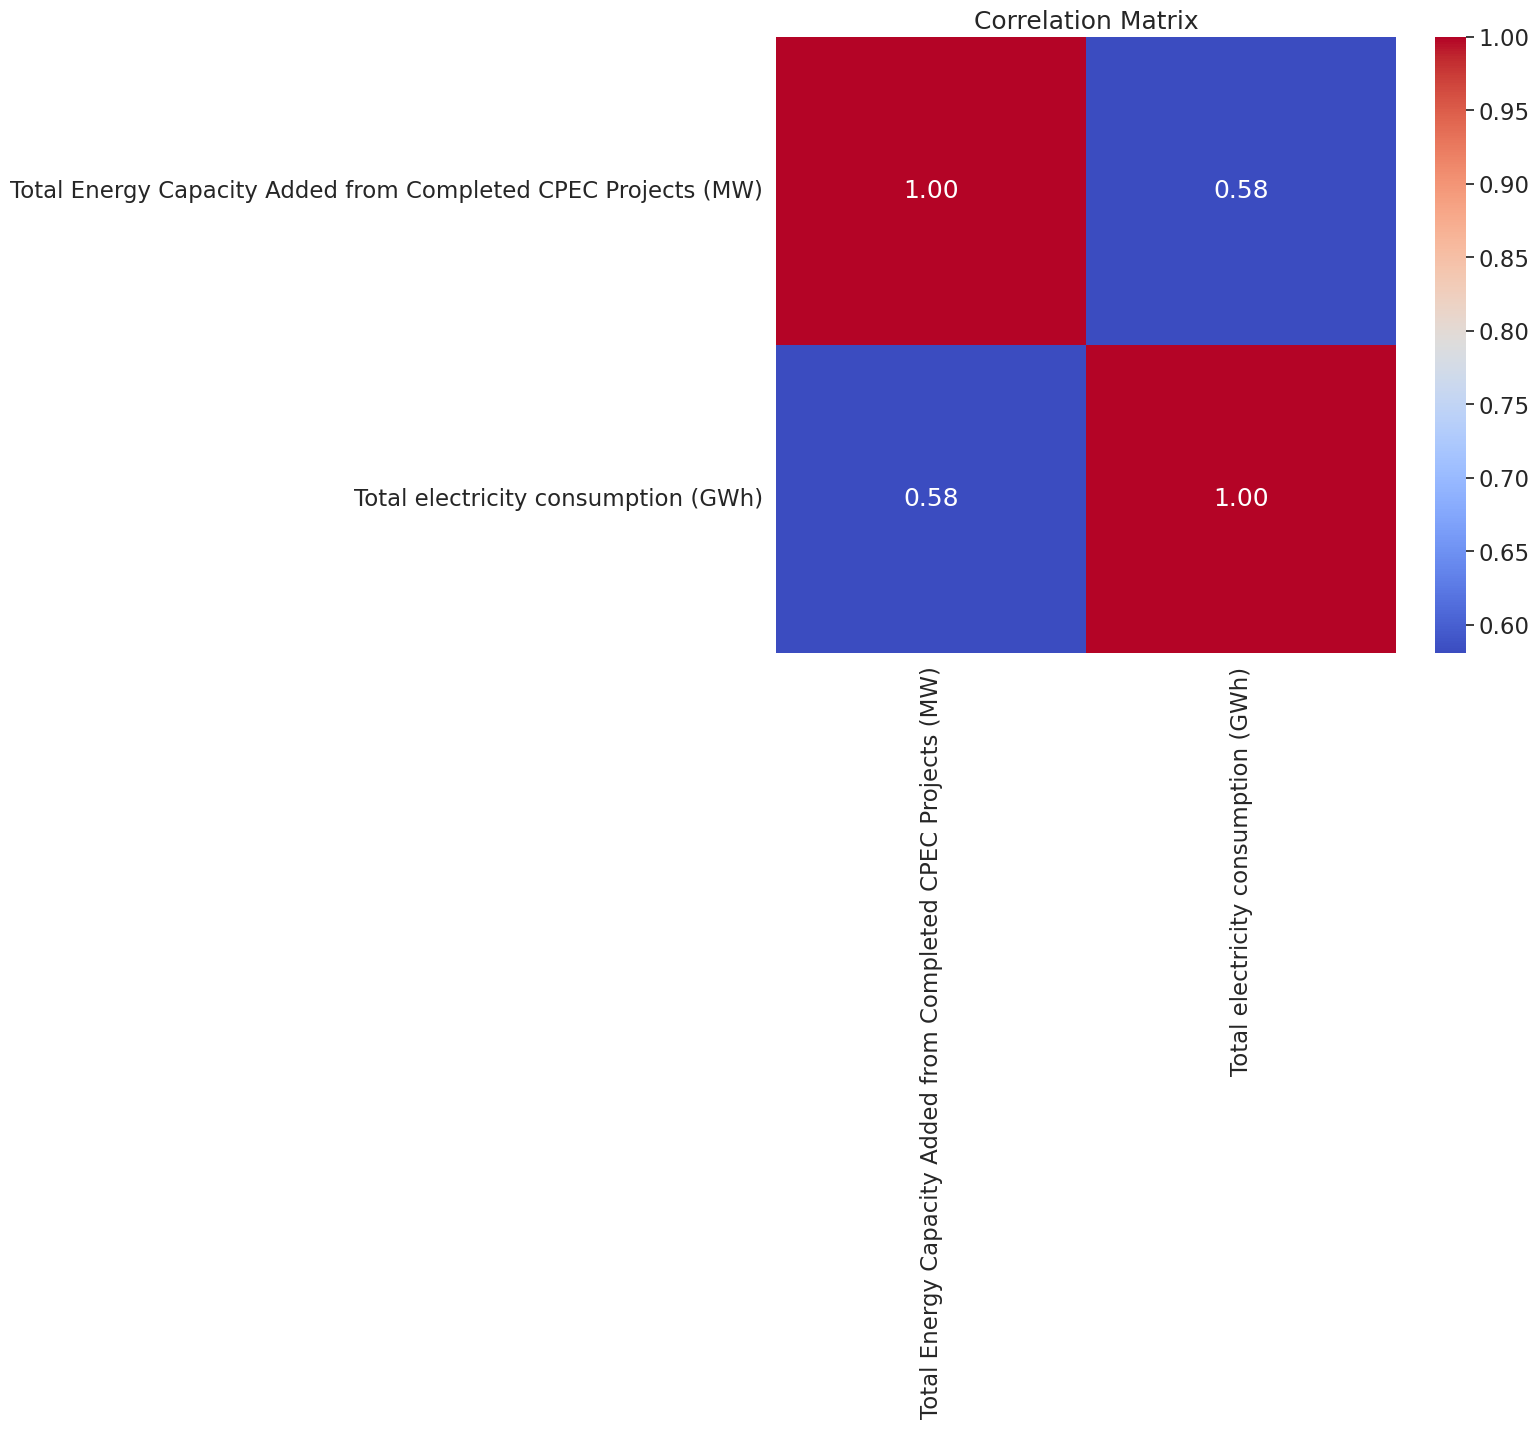

In [98]:
sns.heatmap(data2[['Total Energy Capacity Added from Completed CPEC Projects (MW)','Total electricity consumption (GWh)']].corr(), # plot a correlation matrix
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') # add a title

In [99]:
#Calculating VIF
#This function is amended from: https://stackoverflow.com/a/51329496/4667568

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(data2, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    # Initialize df with data_cleaned to ensure it's defined
    df2 = data2.copy()

    while True:
        #Adding a constant item to the data
        df_with_const2 = add_constant(df2)

        vif_df2 = pd.Series([variance_inflation_factor(df_with_const2.values, i)
               for i in range(df_with_const2.shape[1])], name= "VIF",
              index=df_with_const2.columns).to_frame()

        #Drop the const as const should not be removed
        vif_df2 = vif_df2.drop('const')

        #Drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df2 = vif_df2.drop(list_var_not_to_remove)

        print('Max VIF:', vif_df2.VIF.max())

        #If the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df2.VIF.max() > thresh:
            #If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df2.index[vif_df.VIF == vif_df2.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df2 = df2.drop(columns = index_to_drop)
        else:
            #No VIF is above threshold, exit the loop
            break

    return df2

In [100]:
vars2=['Total Energy Capacity Added from Completed CPEC Projects (MW)','Total electricity consumption (GWh)']

vif2 = drop_column_using_vif_(data2[vars2], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif2.columns)

Max VIF: 1.509341863425538
The columns remaining after VIF selection are:
Index(['Total Energy Capacity Added from Completed CPEC Projects (MW)', 'Total electricity consumption (GWh)'], dtype='object')


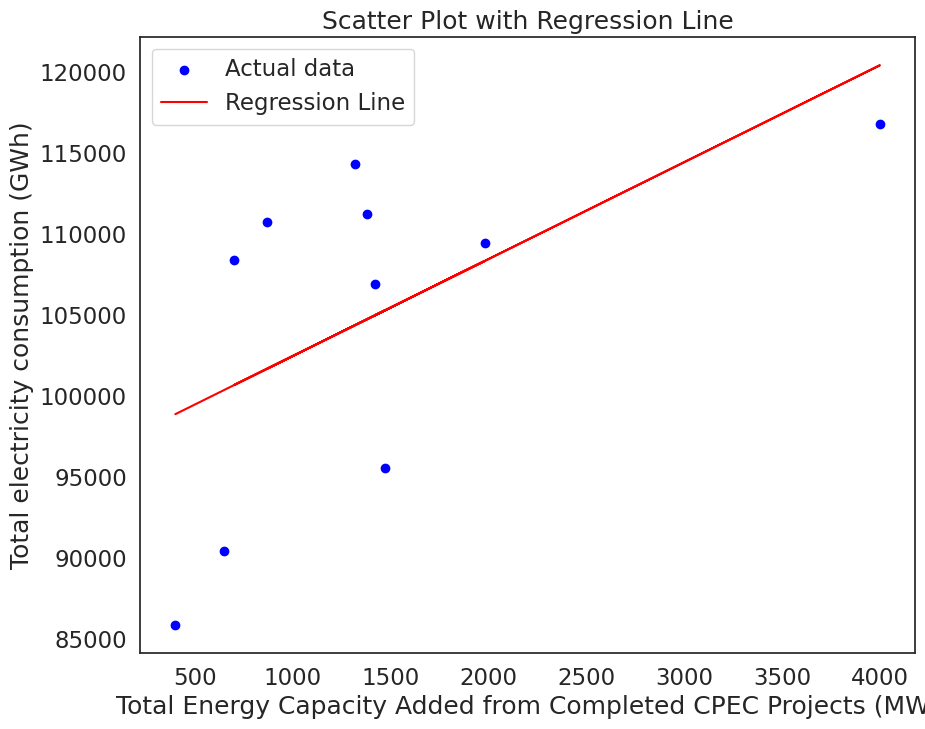

In [104]:
#Select features (X) and target (y)
X = data2[['Total Energy Capacity Added from Completed CPEC Projects (MW)']]
y = data2['Total electricity consumption (GWh)']

#Perform Linear Regression
model2 = LinearRegression()
model2.fit(X, y)

#Predict values using the regression model
y_pred = model2.predict(X)

#Create the scatter plot
plt.scatter(X, y, color='blue', label='Actual data')

#Plot the regression line
plt.plot(X, y_pred, color='red', label='Regression Line')

#Add labels and title
plt.xlabel('Total Energy Capacity Added from Completed CPEC Projects (MW)')
plt.ylabel('Total electricity consumption (GWh)')
plt.title('Scatter Plot with Regression Line')
plt.legend()

#Show the plot
plt.show()

In [101]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

In [102]:
model2_sm = ols('Q("Total electricity consumption (GWh)") ~ Q("Total Energy Capacity Added from Completed CPEC Projects (MW)")', data=data2).fit()
print(model2_sm.summary())

                                       OLS Regression Results                                       
Dep. Variable:     Q("Total electricity consumption (GWh)")   R-squared:                       0.337
Model:                                                  OLS   Adj. R-squared:                  0.255
Method:                                       Least Squares   F-statistic:                     4.075
Date:                                      Thu, 02 Jan 2025   Prob (F-statistic):             0.0782
Time:                                              16:26:53   Log-Likelihood:                -104.25
No. Observations:                                        10   AIC:                             212.5
Df Residuals:                                             8   BIC:                             213.1
Df Model:                                                 1                                         
Covariance Type:                                  nonrobust                                

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


In [103]:
print('The t-statistic for this regression model is 2.019.')
print('The p-value for this regression model is 0.078.')
print('As the p-value is more than 0.05, the null hypothesis is not rejected, and there is no statistically significant relationship between the two variables.')

The t-statistic for this regression model is 2.019.
The p-value for this regression model is 0.078.
As the p-value is more than 0.05, the null hypothesis is not rejected, and there is no statistically significant relationship between the two variables.


In [25]:
#Draw graphs "inline" in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np
#Make the plots (graphs) a little wider by default
pylab.rcParams['figure.figsize'] = (10., 8.)
sns.set(font_scale=1.5)
sns.set_style("white")

from google.colab import files

# Upload the file
uploaded = files.upload()




Saving Data Group14 Coursework.xlsx to Data Group14 Coursework (1).xlsx


In [80]:
import pandas as pd

#Name of uploaded file
file_name = 'Data Group14 Coursework.xlsx'

#Read data from the two sheets
sheet1_df_p2 = pd.read_excel(file_name, sheet_name='Access to electricity')
sheet2_df_p2 = pd.read_excel(file_name, sheet_name='TECA')

def remove_unnamed_columns(df):
  """Removes columns with names starting with 'Unnamed'."""
  unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
  return df.drop(columns=unnamed_cols)

sheet1_df_p2_cleaned = remove_unnamed_columns(sheet1_df_p2)
sheet2_df_p2_cleaned = remove_unnamed_columns(sheet2_df_p2)

In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#Merge the two DataFrames based on the 'Year' column
data2 = pd.merge(sheet1_df_p2_cleaned, sheet2_df_p2_cleaned, on='Year')
data2.head()



,Year,Access to electricity (% of population),Total Energy Capacity Added from Completed CPEC Projects (MW)
0,2015.0,91.0,400
1,2016.0,91.8,650
2,2017.0,92.7,1469
3,2018.0,93.4,1420
4,2019.0,93.9,1980


In [82]:
summary2=data2.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary2

,Year,Access to electricity (% of population),Total Energy Capacity Added from Completed CPEC Projects (MW)
count,10.00,10.00,10.00
mean,2019.50,93.88,1419.00
std,3.03,1.65,1023.98
min,2015.00,91.00,400.00
25%,2017.25,92.88,743.25
50%,2019.50,94.20,1350.00
75%,2021.75,94.98,1456.75
max,2024.00,96.03,4000.00


In [83]:
Q1_2 = data2.quantile(0.25)
Q3_2 = data2.quantile(0.75)
IQR_2 = Q3_2 - Q1_2

#Define outliers as data points outside of Q1 - 1.5*IQR or Q3 + 1.5*IQR
outliers2 = ((data2 < (Q1_2 - 1.5 * IQR_2)) | (data2 > (Q3_2 + 1.5 * IQR_2))).any(axis=1)

#Remove outliers
data_cleaned2 = data2[~outliers]
print(data_cleaned2)

     Year  Access to electricity (% of population)  \
0  2015.0                                    91.00   
1  2016.0                                    91.80   
2  2017.0                                    92.70   
3  2018.0                                    93.40   
4  2019.0                                    93.90   
5  2020.0                                    94.50   
6  2021.0                                    94.90   
7  2022.0                                    95.00   
8  2023.0                                    95.60   
9  2024.0                                    96.03   

   Total Energy Capacity Added from Completed CPEC Projects (MW)  
0                                                400              
1                                                650              
2                                               1469              
3                                               1420              
4                                               1980              
5  

In [ ]:

def filter_outliers(var):
    q1 = var.quantile(0.25) # calculate the first quartile
    q3 = var.quantile(0.75) # calculate the third quartile
    iqr = q3 - q1 # calculate the interquartile range
    low = q1 - 3*iqr # calculate the lower bound
    high = q3 + 3*iqr # calculate the upper bound
    filtered = data2[(var > low) & (var < high)] # filter  the values that are within the bounds
    dropped_observations= len(var)-len(filtered) # calculate the number of observations that were dropped

    print('Dropped {} observations'.format(dropped_observations))
    return  filtered


Text(69.75, 0.5, 'Total Energy Capacity Added from Completed CPEC Projects (MW)')

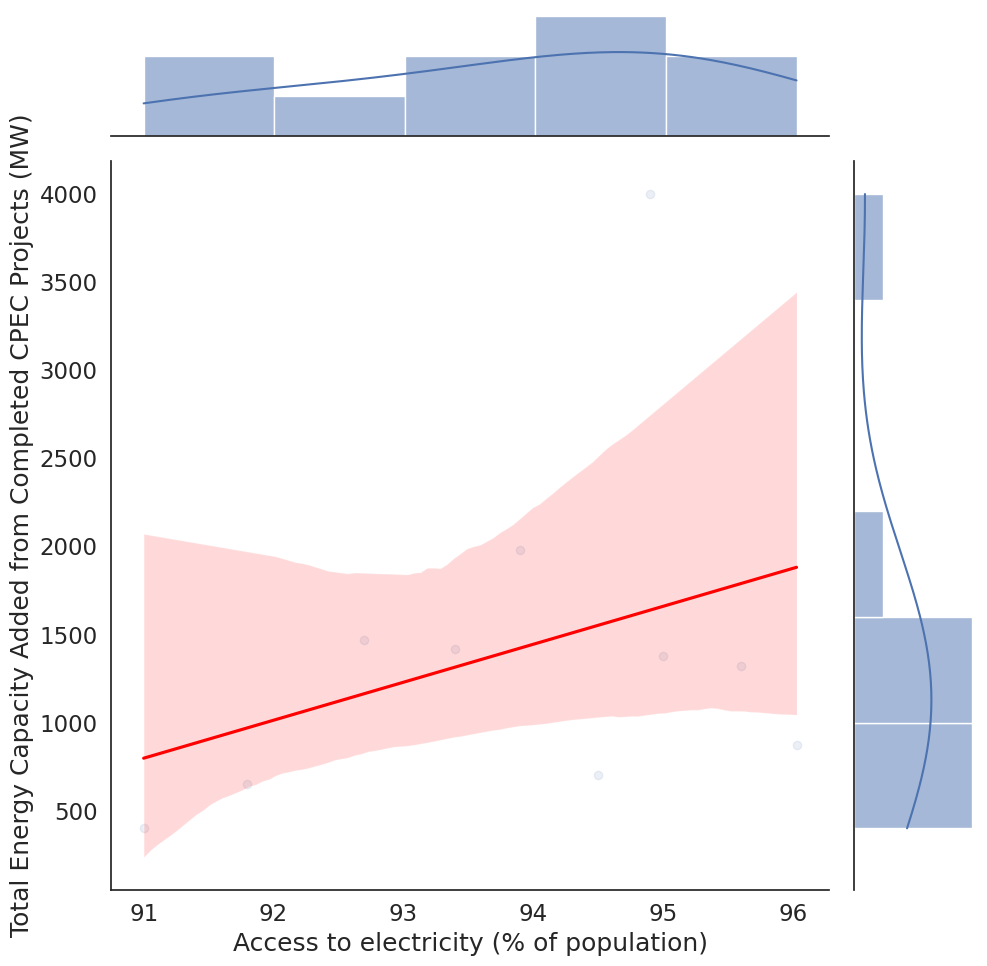

In [84]:
sns.jointplot(data=data2, # plot a scatterplot with a regression line and two histograms
                x='Access to electricity (% of population)', # set the x axis to be the years of schooling
                y='Total Energy Capacity Added from Completed CPEC Projects (MW)', # set the y axis to be the hourly wage
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Access to electricity (% of population)') # add a label to the x axis
plt.ylabel('Total Energy Capacity Added from Completed CPEC Projects (MW)') # add a label to the y axis

Text(0.5, 1.0, 'Correlation Matrix')

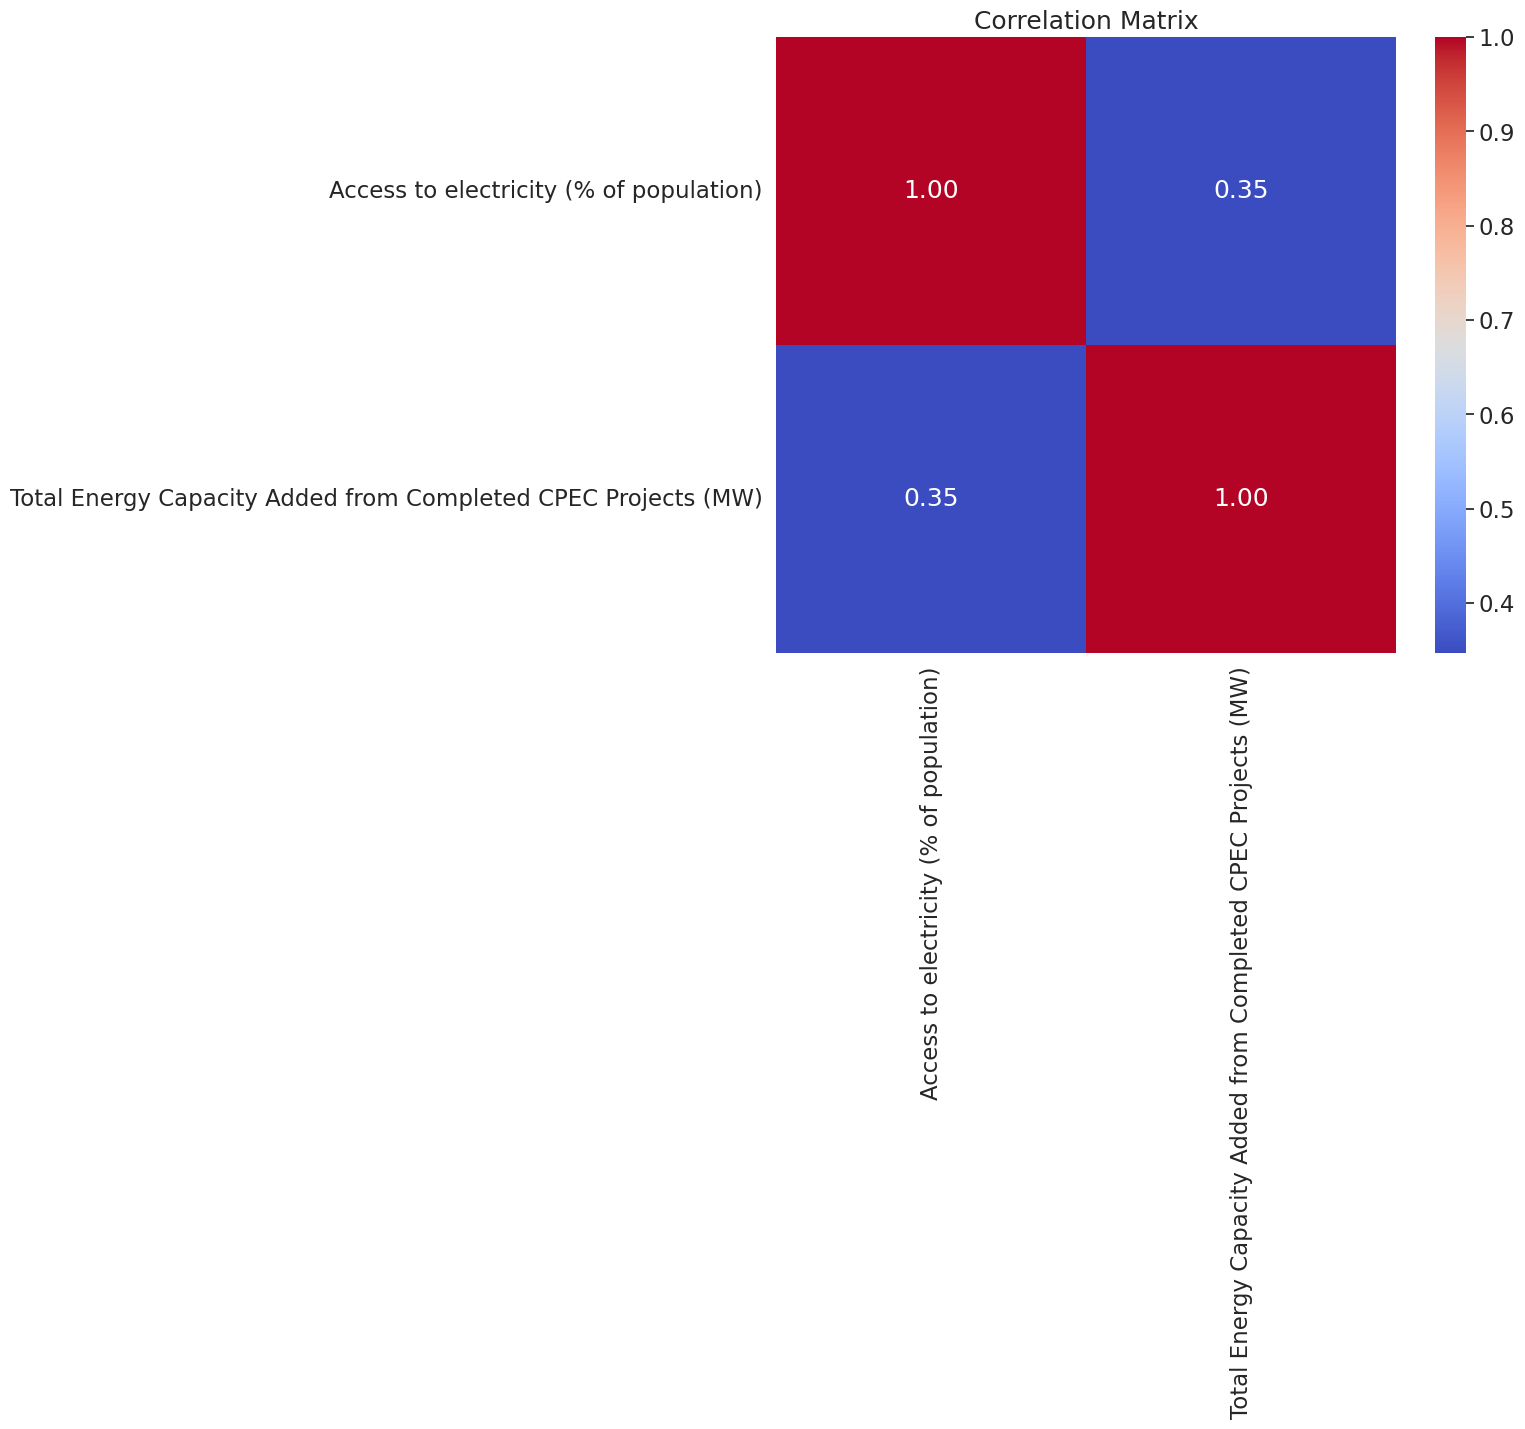

In [85]:

sns.heatmap(data2[['Access to electricity (% of population)','Total Energy Capacity Added from Completed CPEC Projects (MW)']].corr(), # plot a correlation matrix
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') # add a title

In [ ]:
# calculating VIF
# This function is amended from: https://stackoverflow.com/a/51329496/4667568

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df2, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''

    # Initialize df2 to ensure it's defined
    df2 = data2.copy()

    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const as const should not be removed
        vif_df = vif_df.drop('const')

        # drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)

        print('Max VIF:', vif_df.VIF.max())

        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [87]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col



In [89]:
model2_sm = ols('Q("Total Energy Capacity Added from Completed CPEC Projects (MW)") ~ Q("Access to electricity (% of population)")', data=data2).fit()
print(model2_sm.summary())

                                                    OLS Regression Results                                                    
Dep. Variable:     Q("Total Energy Capacity Added from Completed CPEC Projects (MW)")   R-squared:                       0.121
Model:                                                                            OLS   Adj. R-squared:                  0.011
Method:                                                                 Least Squares   F-statistic:                     1.096
Date:                                                                Thu, 02 Jan 2025   Prob (F-statistic):              0.326
Time:                                                                        15:56:45   Log-Likelihood:                -82.335
No. Observations:                                                                  10   AIC:                             168.7
Df Residuals:                                                                       8   BIC:                   

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


In [29]:
#Draw graphs "inline" in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np
#Make the plots (graphs) a little wider by default
pylab.rcParams['figure.figsize'] = (10., 8.)
sns.set(font_scale=1.5)
sns.set_style("white")

In [30]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving Data Group14 Coursework.xlsx to Data Group14 Coursework (2).xlsx


In [33]:
import pandas as pd

#Name of uploaded file
file_name = 'Data Group14 Coursework.xlsx'

#Read data from the two sheets
sheet1_df3 = pd.read_excel(file_name, sheet_name='BRI investments')
sheet2_df3 = pd.read_excel(file_name, sheet_name='Access to electricity')

sheet1_df3_cleaned = remove_unnamed_columns(sheet1_df3)
sheet2_df3_cleaned = remove_unnamed_columns(sheet2_df3)

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#Merge the two DataFrames based on the 'Year' column
data3 = pd.merge(sheet1_df3_cleaned, sheet2_df3_cleaned, on='Year')
data3.head()

,Year,BRI Investments in Energy Sector (USD millions),Access to electricity (% of population)
0,2015,520.40,91.0
1,2016,893.25,91.8
2,2017,2296.00,92.7
3,2018,2062.00,93.4
4,2019,2907.00,93.9


In [38]:
#Generate summary statistics, and round everything to 2 decimal places
summary3=data3.describe().round(2)
summary3

,Year,BRI Investments in Energy Sector (USD millions),Access to electricity (% of population)
count,10.00,10.00,10.00
mean,2019.50,1809.26,93.88
std,3.03,750.38,1.65
min,2015.00,520.40,91.00
25%,2017.25,1480.00,92.88
50%,2019.50,1829.00,94.20
75%,2021.75,2237.50,94.98
max,2024.00,2907.00,96.03


In [39]:
Q1_3 = data3.quantile(0.25)
Q3_3 = data3.quantile(0.75)
IQR_3 = Q3_3 - Q1_3

#Define outliers
outliers = ((data3 < (Q1_3 - 1.5 * IQR_3)) | (data3 > (Q3_3 + 1.5 * IQR_3))).any(axis=1)

#Remove outliers
data3_cleaned = data3[~outliers]
print(data3_cleaned)

   Year  BRI Investments in Energy Sector (USD millions)  \
0  2015                                           520.40   
1  2016                                           893.25   
2  2017                                          2296.00   
3  2018                                          2062.00   
4  2019                                          2907.00   
5  2020                                          1600.00   
6  2021                                          1658.00   
7  2022                                          2716.00   
8  2023                                          1440.00   
9  2024                                          2000.00   

   Access to electricity (% of population)  
0                                    91.00  
1                                    91.80  
2                                    92.70  
3                                    93.40  
4                                    93.90  
5                                    94.50  
6                       

Text(69.75, 0.5, 'Access to electricity (% of population)')

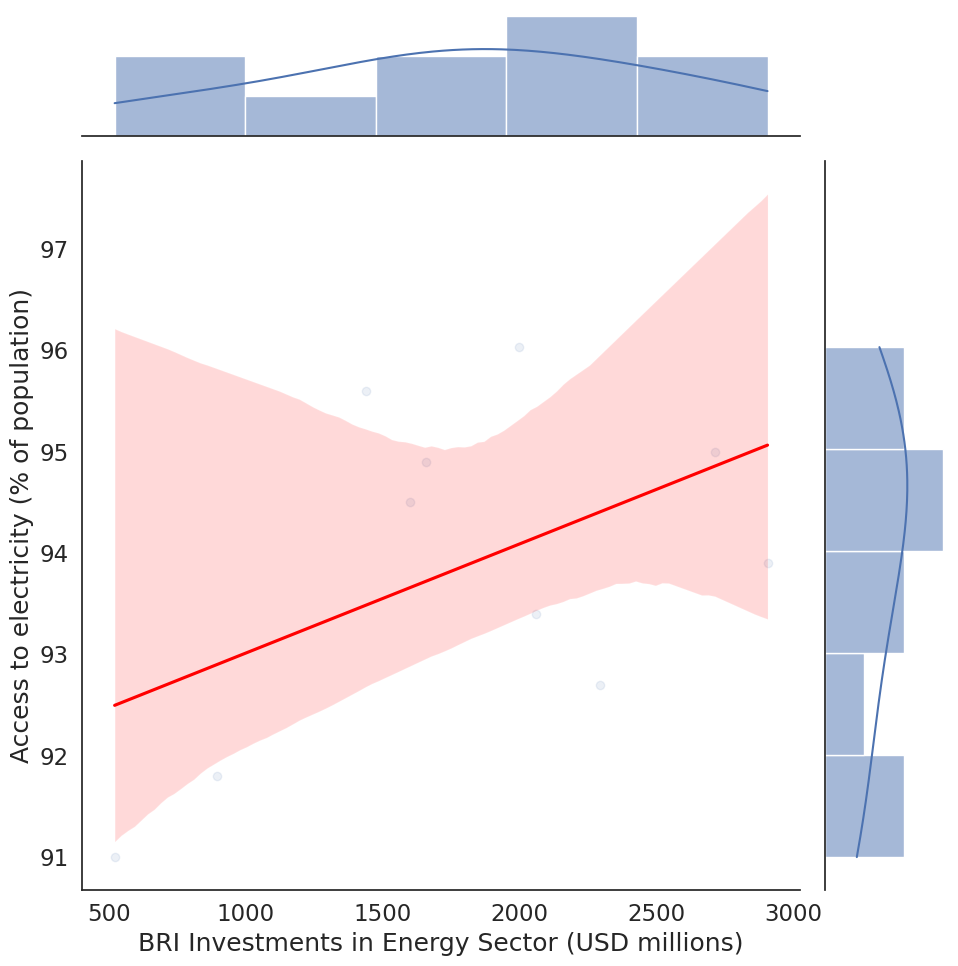

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#Plot scatterplot and two histograms
sns.jointplot(data=data3_cleaned,
              x='BRI Investments in Energy Sector (USD millions)',
              y='Access to electricity (% of population)',
              kind="reg",
              scatter_kws=dict(alpha=0.1),
              line_kws=dict(color='red'),
              height=10)

#Add labels to the axes
plt.xlabel('BRI Investments in Energy Sector (USD millions)')
plt.ylabel('Access to electricity (% of population)')

Text(0.5, 1.0, 'Correlation Matrix')

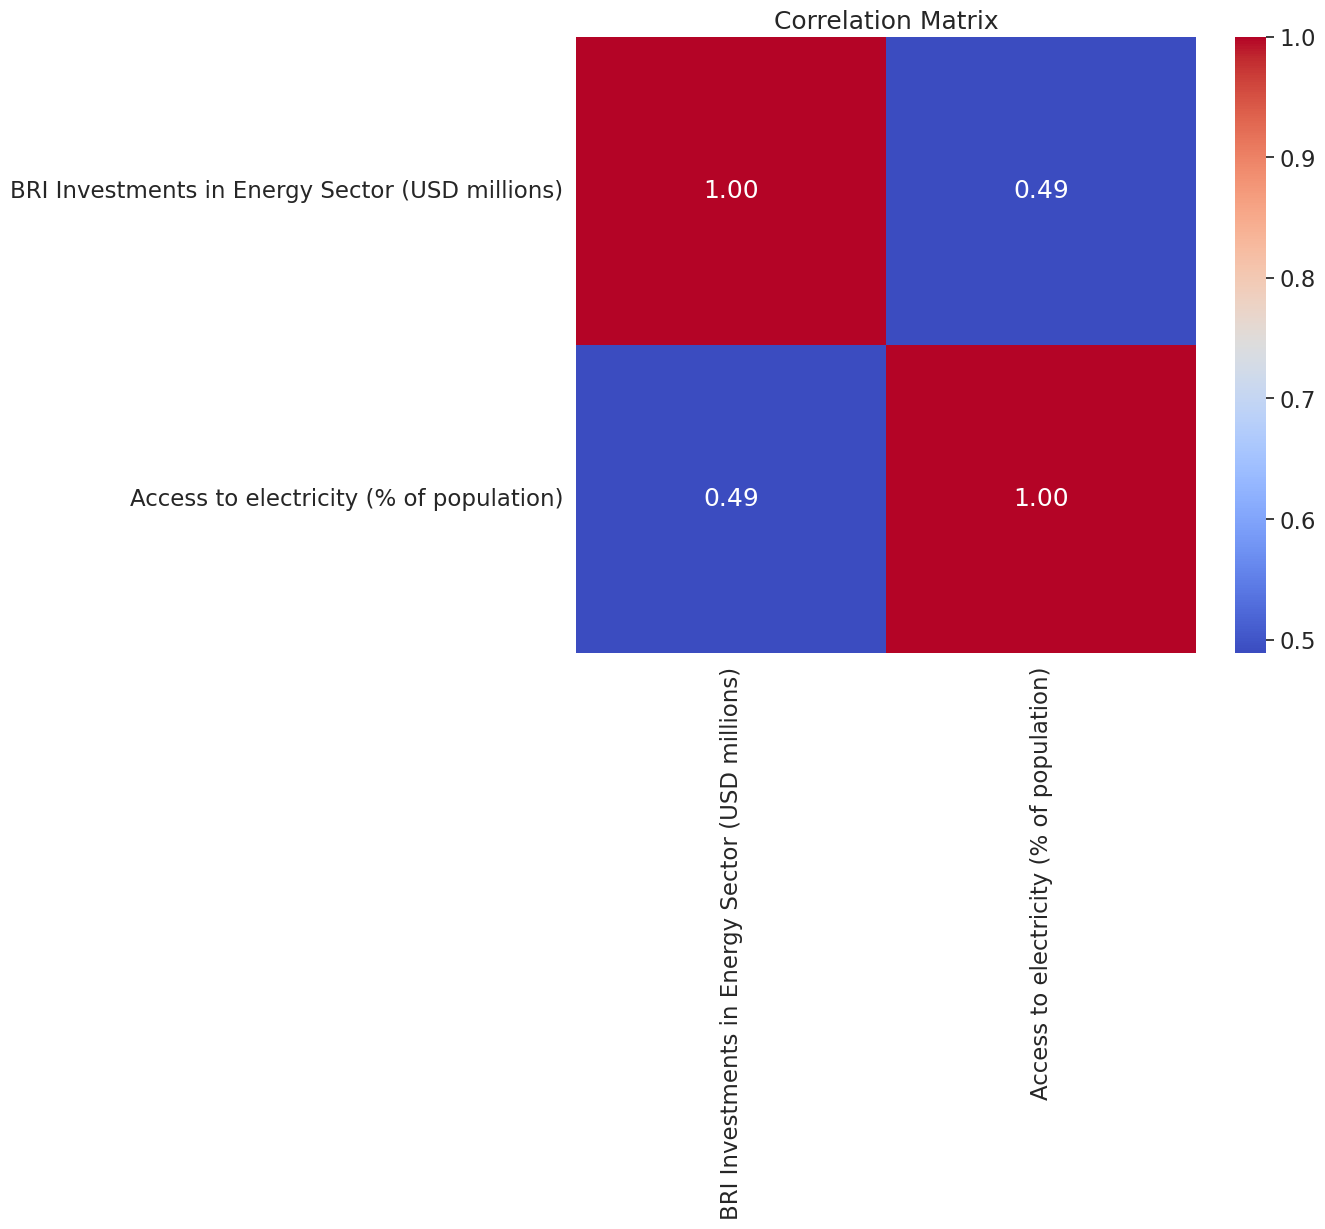

In [41]:
sns.heatmap(data3_cleaned[['BRI Investments in Energy Sector (USD millions)','Access to electricity (% of population)']].corr(), #Plot a correlation matrix
            annot=True, #Show the correlation values on the plot
            fmt=".2f", #Set the format of the correlation values to be two decimal places
            cmap='coolwarm') #Set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') #Add a title

In [64]:
#Calculating VIF
#This function is amended from: https://stackoverflow.com/a/51329496/4667568

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df3, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    # Initialize df with data_cleaned to ensure it's defined
    df3 = data3_cleaned.copy()

    while True:
        # adding a constatnt item to the data
        df_with_const3 = add_constant(df3)

        vif_df3 = pd.Series([variance_inflation_factor(df_with_const3.values, i)
               for i in range(df_with_const3.shape[1])], name= "VIF",
              index=df_with_const3.columns).to_frame()

        # drop the const as const should not be removed
        vif_df3 = vif_df3.drop('const')

        # drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df3 = vif_df3.drop(list_var_not_to_remove)

        print('Max VIF:', vif_df3.VIF.max())

        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df3.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df3.index[vif_df3.VIF == vif_df3.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df3 = df3.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df3

In [65]:
vars3=['BRI Investments in Energy Sector (USD millions)','Access to electricity (% of population)']

vif3 = drop_column_using_vif_(data3_cleaned[vars3], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif3.columns)

Max VIF: 43.38828909746683
Dropping: Access to electricity (% of population)
Max VIF: 1.200856169122515
The columns remaining after VIF selection are:
Index(['Year', 'BRI Investments in Energy Sector (USD millions)'], dtype='object')


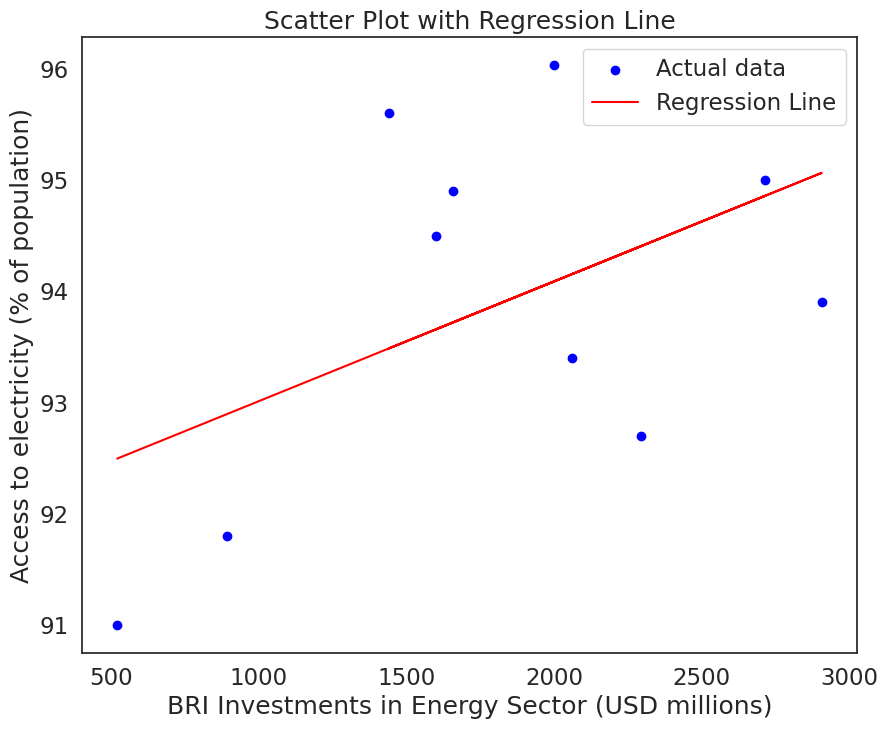

In [68]:
#Select features (X) and target (y)
X = data3_cleaned[['BRI Investments in Energy Sector (USD millions)']]
y = data3_cleaned['Access to electricity (% of population)']

#Perform Linear Regression
model = LinearRegression()
model.fit(X, y)

#Predict values using the regression model
y_pred = model.predict(X)

#Create the scatter plot
plt.scatter(X, y, color='blue', label='Actual data')

#Plot the regression line
plt.plot(X, y_pred, color='red', label='Regression Line')

#Add labels and title
plt.xlabel('BRI Investments in Energy Sector (USD millions)')
plt.ylabel('Access to electricity (% of population)')
plt.title('Scatter Plot with Regression Line')
plt.legend()

#Show the plot
plt.show()

In [69]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

In [70]:
#Fit the model
model3=ols('Q("Access to electricity (% of population)") ~ Q("BRI Investments in Energy Sector (USD millions)")', data=data3_cleaned).fit()
print(model3.summary())

                                         OLS Regression Results                                         
Dep. Variable:     Q("Access to electricity (% of population)")   R-squared:                       0.239
Model:                                                      OLS   Adj. R-squared:                  0.144
Method:                                           Least Squares   F-statistic:                     2.515
Date:                                          Thu, 02 Jan 2025   Prob (F-statistic):              0.151
Time:                                                  15:36:23   Log-Likelihood:                -17.304
No. Observations:                                            10   AIC:                             38.61
Df Residuals:                                                 8   BIC:                             39.21
Df Model:                                                     1                                         
Covariance Type:                                      n

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


In [71]:
print('The t-statistic for this regression model is 1.586.')
print('The p-value for this regression model is 0.151.')
print('As the p-value is more than 0.05, the null hypothesis is not rejected, and there is no a statistically significant relationship between the two variables.')

The t-statistic for this regression model is 1.586.
The p-value for this regression model is 0.151.
As the p-value is more than 0.05, the null hypothesis is not rejected, and there is no a statistically significant relationship between the two variables.
